In [1]:
import findspark
findspark.init()
import pyspark

sc = pyspark.SparkContext(master='spark://hd-master:7077',
                          appName='big_data')

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

print('Modules are imported.')

Modules are imported.


In [ ]:
spark = SQLContext(sc)

In [4]:
covid_data = spark.read.option("header", True).csv("hdfs://hd-master:9000/covid-19", inferSchema=True)
covid_data.show(5, truncate=False)

In [5]:
# Perform necessary data transformations
covid_data = covid_data.withColumn("date", F.to_date("date", "yyyy-MM-dd"))

# Visualize one country (e.g., China)
one_country_data = covid_data.filter(F.col("country") == "china")
one_country_data = one_country_data.withColumn("date", F.to_date("date"))

# Convert PySpark DataFrame to Pandas DataFrame for visualization
one_country_pandas_df = one_country_data.toPandas()

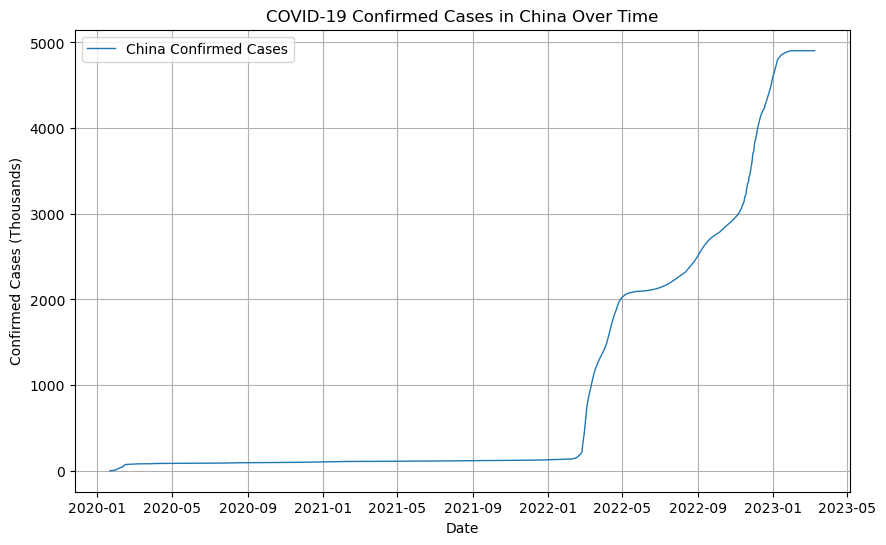

In [6]:
# Visualize one country
plt.figure(figsize=(10, 6))
plt.plot(one_country_pandas_df['date'], one_country_pandas_df['confirmed'], label='China Confirmed Cases', linewidth=1)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))

plt.title('COVID-19 Confirmed Cases in China Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases (Thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Calculate daily confirmed cases for selected countries
countries = ['china', 'canada', 'us', 'vietnam']
windowSpec = Window.partitionBy("country").orderBy("date")

selected_countries_data = covid_data.filter(F.col("country").isin(countries))
selected_countries_data = selected_countries_data.withColumn("daily_confirmed", F.col("confirmed") - F.lag("confirmed").over(windowSpec))

In [8]:

# Convert PySpark DataFrame to Pandas DataFrame for visualization
selected_countries_pandas_df = selected_countries_data.toPandas()

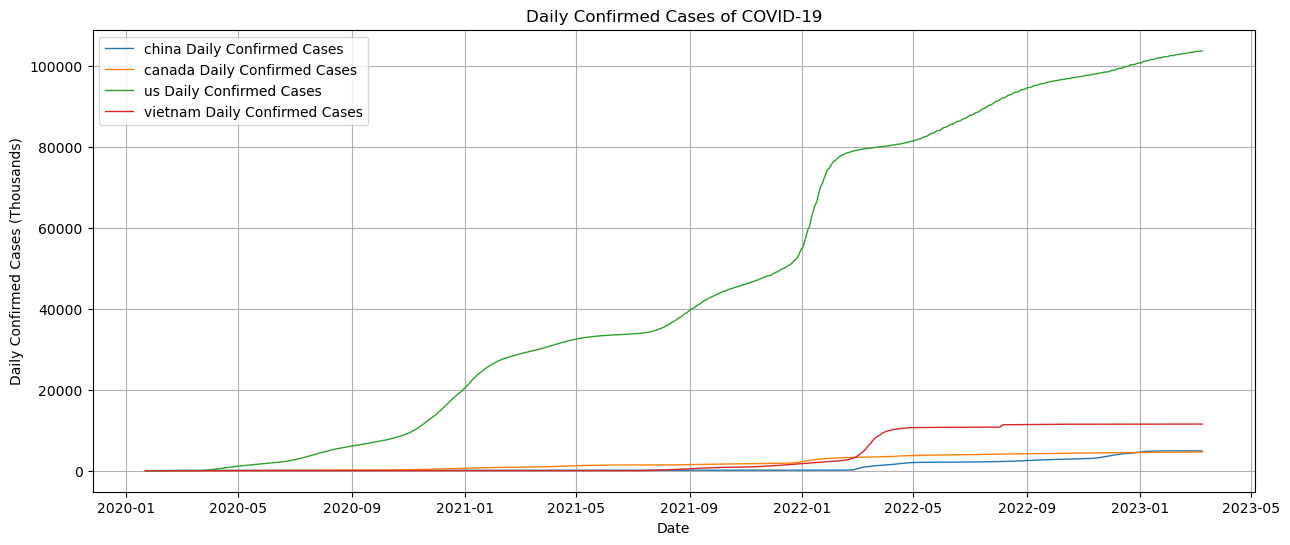

In [9]:
# Visualize daily confirmed cases for selected countries
plt.figure(figsize=(15, 6))
for country in countries:
    country_data = selected_countries_pandas_df[selected_countries_pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['confirmed'], label=f'{country} Daily Confirmed Cases', linewidth=1)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.title('Daily Confirmed Cases of COVID-19')
plt.xlabel('Date')
plt.ylabel('Daily Confirmed Cases (Thousands)')
plt.legend()
plt.grid(True)
plt.show()

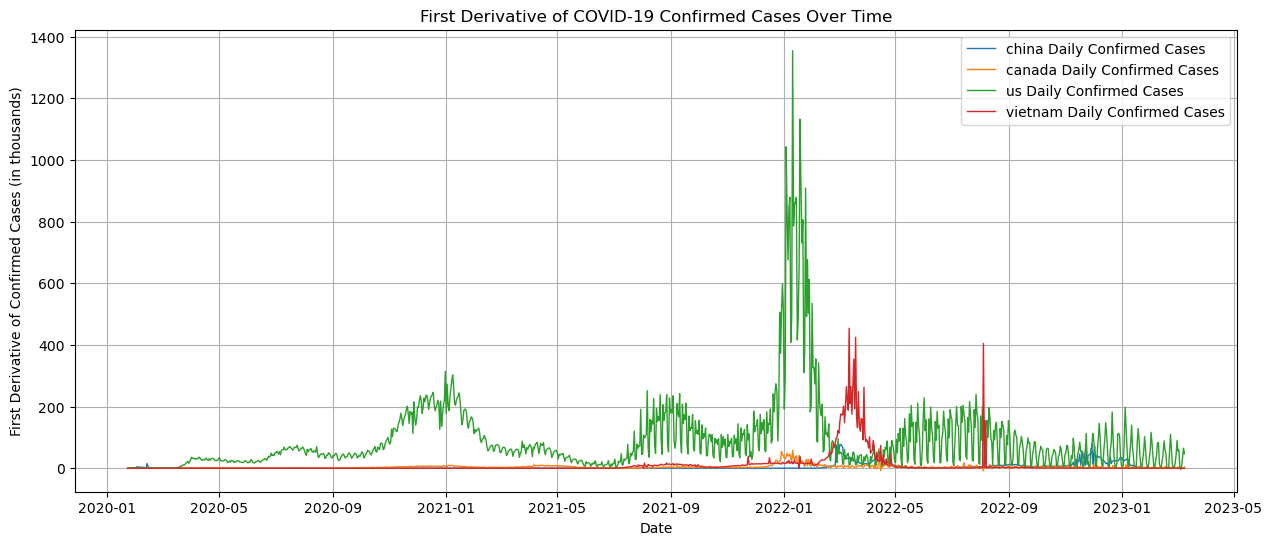

In [10]:
# Visualize daily confirmed cases for selected countries
plt.figure(figsize=(15, 6))
for country in countries:
    country_data = selected_countries_pandas_df[selected_countries_pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['daily_confirmed'], label=f'{country} Daily Confirmed Cases', linewidth=1)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.title('First Derivative of COVID-19 Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('First Derivative of Confirmed Cases (in thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Stop the Spark session
sc.stop()